# Dataset analysis

Plots and stats for the human dataset, after removing outliers, before sequence clustering.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
)
from subpred.util import get_feature_score
from subpred.pssm import calculate_pssms_notebook
import seaborn as sns
import matplotlib.pyplot as plt

## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [9606],
    output_log = "../logs/human_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,0.0,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,2.A,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,2.A,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,2.A,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,2.A,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...


### Stats

Imbalanced dataset, the number of sugar transporters might be a bit low.

In [4]:
df.keywords_transport.value_counts()

Amino-acid transport    51
Sugar transport         34
Name: keywords_transport, dtype: int64

In [5]:
df.keywords_location.value_counts()

Cell membrane;Membrane;Transmembrane                                 36
Membrane;Transmembrane                                               36
Endoplasmic reticulum;Membrane;Transmembrane                          6
Membrane;Mitochondrion;Transmembrane                                  4
Membrane;Mitochondrion;Mitochondrion inner membrane;Transmembrane     3
Name: keywords_location, dtype: int64

In [6]:
df.keywords_transport_related.value_counts()

Transport                     57
Symport;Transport             23
Antiport;Transport             4
Antiport;Symport;Transport     1
Name: keywords_transport_related, dtype: int64

#### TCDB


In [7]:
df.tcdb_class.value_counts()

2.A    83
0.0     2
Name: tcdb_class, dtype: int64

## Feature generation

In [31]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)
df_pssm = calculate_pssms_notebook(sequences=df.sequence)

Hierarchical clustering can't quite distinguish all transporters into their categories:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdfd05a3d60>)

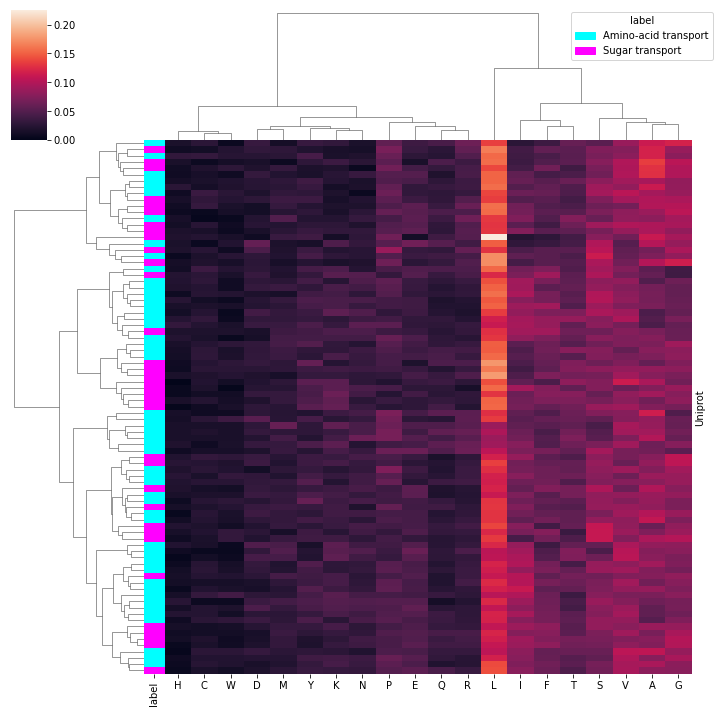

In [9]:
labeled_clustermap(df_aac, labels, xlabels="auto")

### PAAC plot

The number of dipeptides with relatively high frequency is even lower than for e coli and a thaliana:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdfd2dc7a00>)

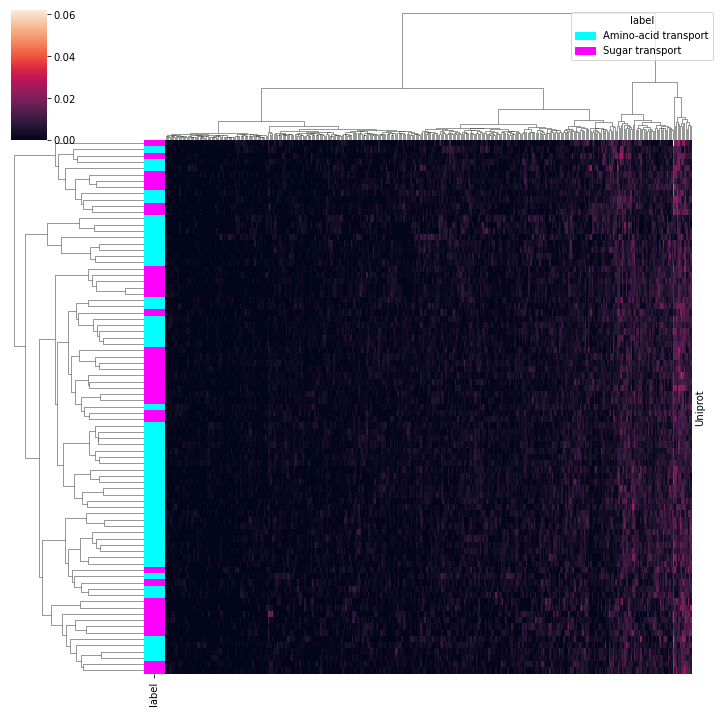

In [10]:
labeled_clustermap(df_paac, labels)

In [23]:
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)

print(len(cluster0))
print(len(cluster1))

from collections import Counter

counter = Counter()
for dipeptide in cluster0:
    counter[dipeptide[0]] += 1
    counter[dipeptide[1]] += 1

counter.most_common()

57
343


[('L', 20),
 ('V', 16),
 ('G', 15),
 ('I', 14),
 ('S', 14),
 ('A', 12),
 ('F', 10),
 ('T', 7),
 ('E', 3),
 ('P', 2),
 ('Y', 1)]

The most common PAAC dipeptides are hydrophobic residues such as leucine, valine, alanine and isoleucine, as well as typical alpha-helix residue glycine. Serine and phenylanaline might be interesting for substrate specificity. 

In [32]:
get_feature_score(df_paac, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).reset_index(drop=True).head(20)

,Feature,Normalized score,Measure
0,RE,0.017928,Feature importance (f_classif)
1,GR,0.015945,Feature importance (f_classif)
2,WP,0.014582,Feature importance (f_classif)
3,VR,0.013965,Feature importance (f_classif)
4,FE,0.013147,Feature importance (f_classif)
5,FP,0.013106,Feature importance (f_classif)
6,TP,0.012879,Feature importance (f_classif)
7,GG,0.012412,Feature importance (f_classif)
8,MH,0.012014,Feature importance (f_classif)
9,YN,0.011622,Feature importance (f_classif)


An important feature seems to be the frequencies of the dipeptides Arginine-Glutamate and Glycine-Arginine.

#### Antiport, Symport, Uniport

No distict clusters show up in the data, when annotating the clusters with transport mechanism.

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7fdfd0678280>)

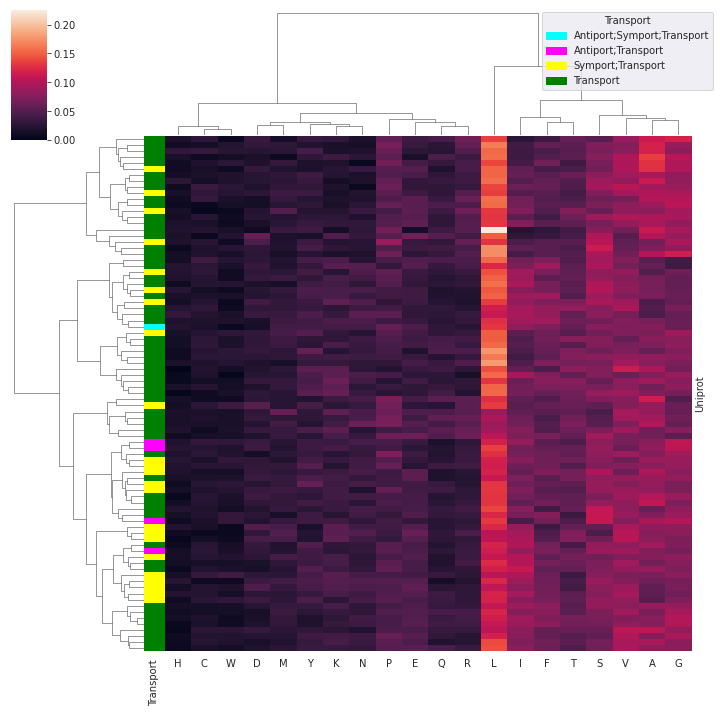

In [33]:
labeled_clustermap(
    df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto"
)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

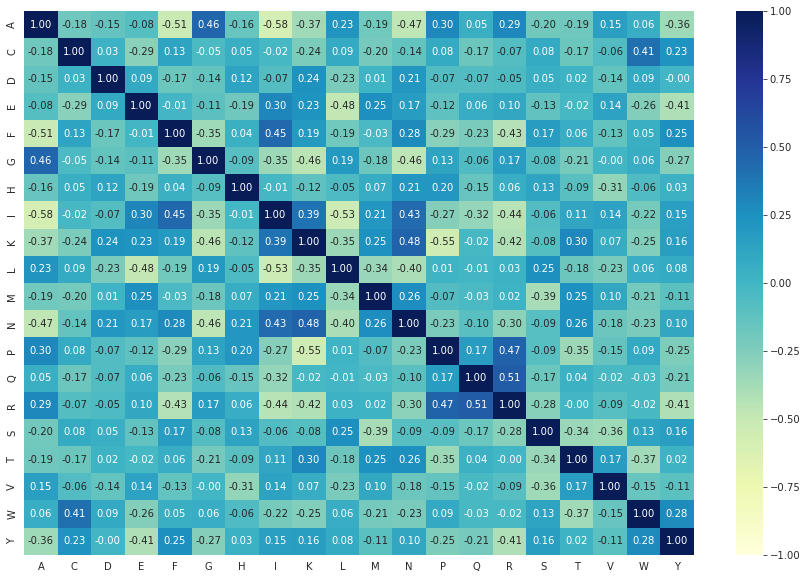

In [28]:
corr_heatmap(df_aac)

<AxesSubplot:>

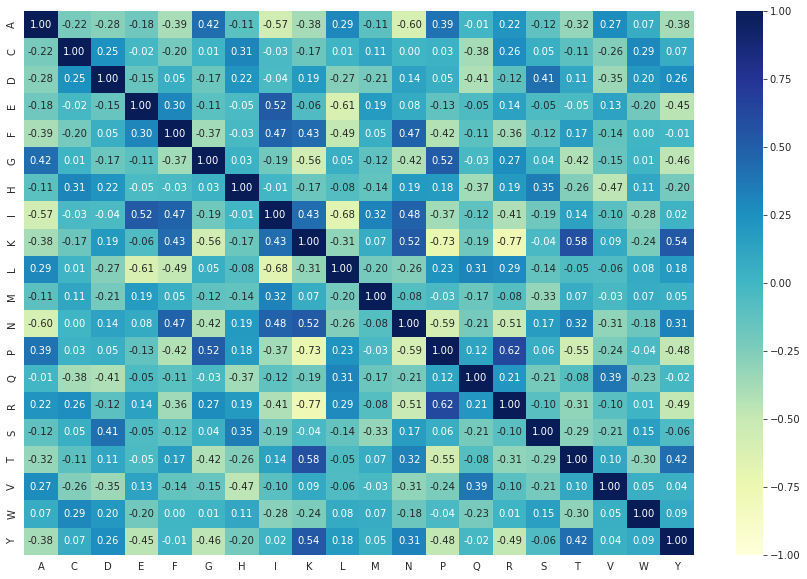

In [29]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

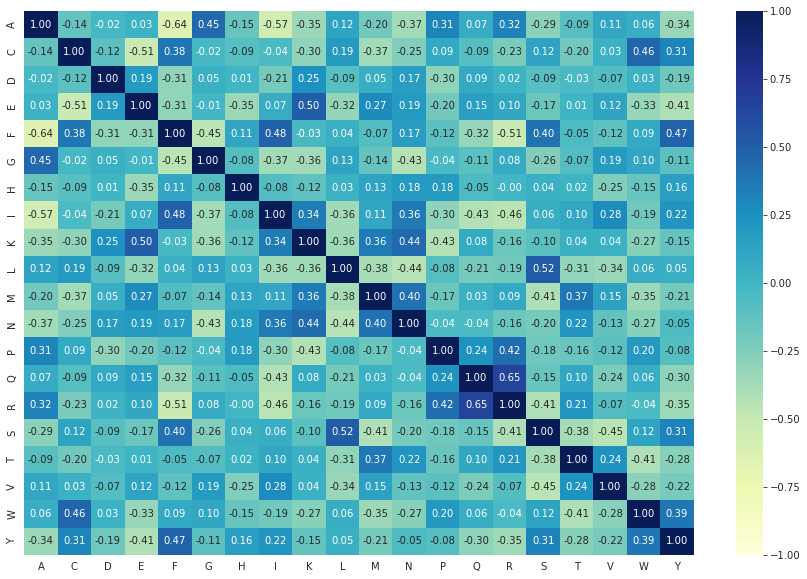

In [30]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

In [36]:
df_aac_long = (
    df_aac.stack(level=None)
    .reset_index()
    .rename(columns={"level_1": "Amino Acid", 0: "Frequency"})
    .merge(df.keywords_transport, left_on="Uniprot", right_index=True)
)
df_aac_long.head()

,Uniprot,Amino Acid,Frequency,keywords_transport
0,Q9BWM7,A,0.090343,Amino-acid transport
1,Q9BWM7,C,0.018692,Amino-acid transport
2,Q9BWM7,D,0.031153,Amino-acid transport
3,Q9BWM7,E,0.037383,Amino-acid transport
4,Q9BWM7,F,0.043614,Amino-acid transport


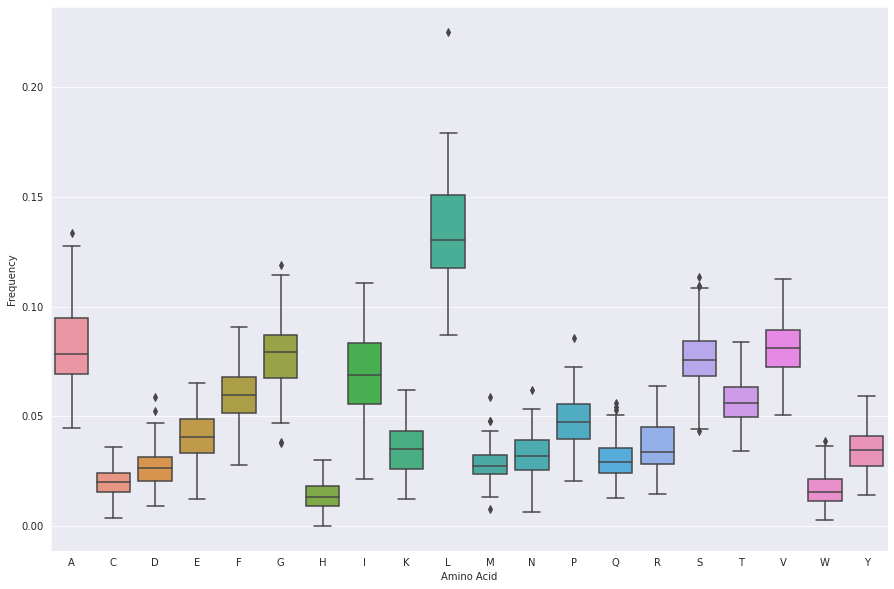

In [37]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    # hue="keywords_transport"
)

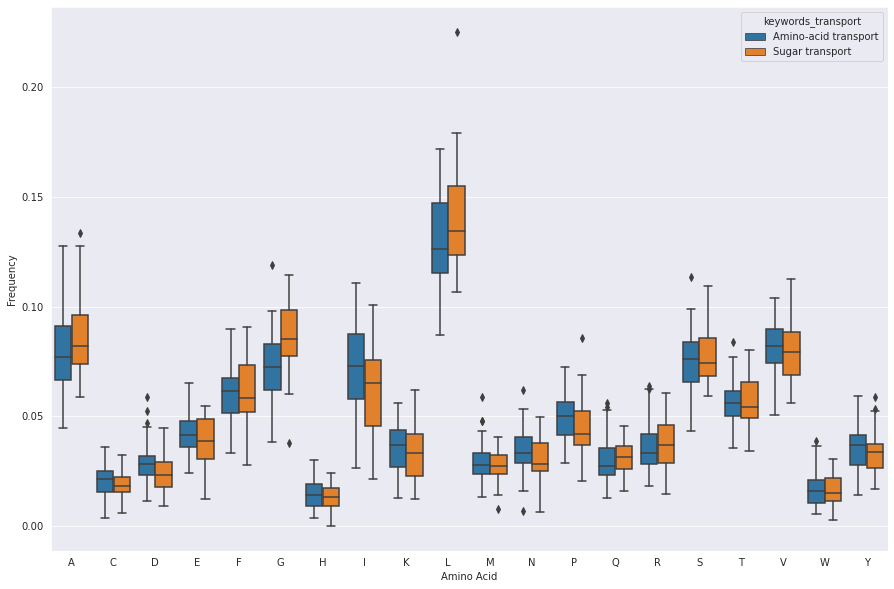

In [38]:
plt.figure(figsize=(15,10))
g = sns.boxplot(
    data=df_aac_long,
    x="Amino Acid",
    y="Frequency",
    hue="keywords_transport"
)

There does not seem to be a clear distinguishing factor. The classification probably has to be carried out using a combination of several features.

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

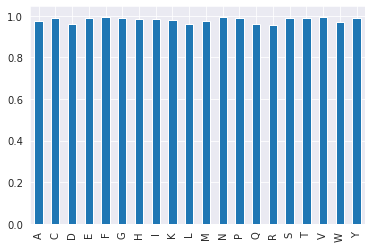

In [39]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

## Additional plots

### TCDB class

The non-TCDB proteins mix well with the 2.A proteins, suggesting that they share a similar sequence composition

({'0.0': 'cyan', '2.A': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdfd1c02880>)

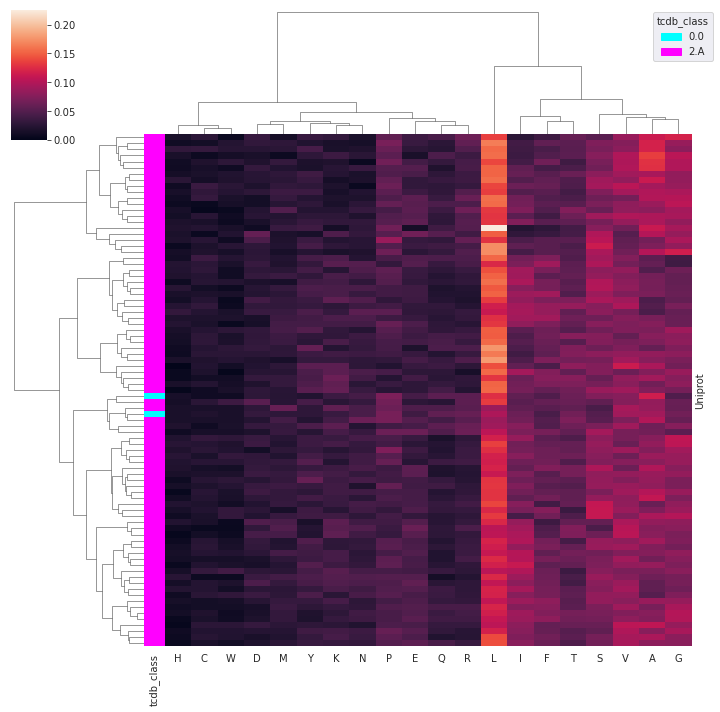

In [40]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")

## PCA plots

PCA plots for AAC and PAAC, the first two and three PC's.

### AAC

The data is not that clearly separable with just the AAC and the first two or thee PCs

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

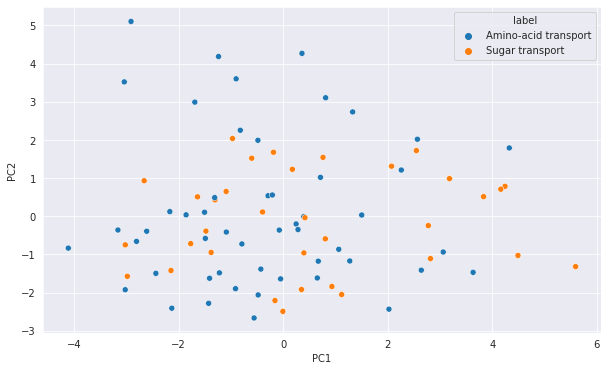

In [41]:
pca_plot_2d(df_aac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

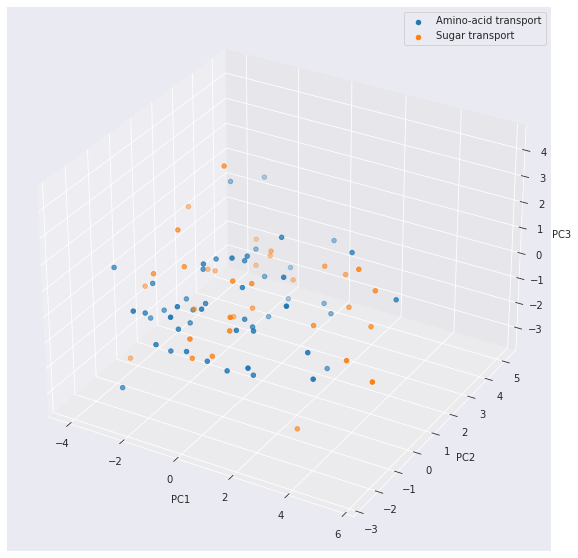

In [42]:
pca_plot_3d(df_aac, labels)

### PAAC



<AxesSubplot:xlabel='PC1', ylabel='PC2'>

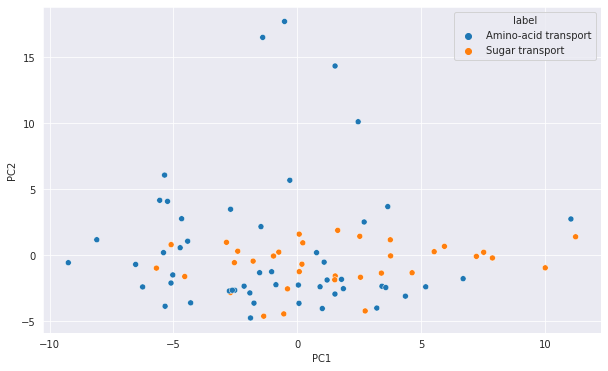

In [43]:
pca_plot_2d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

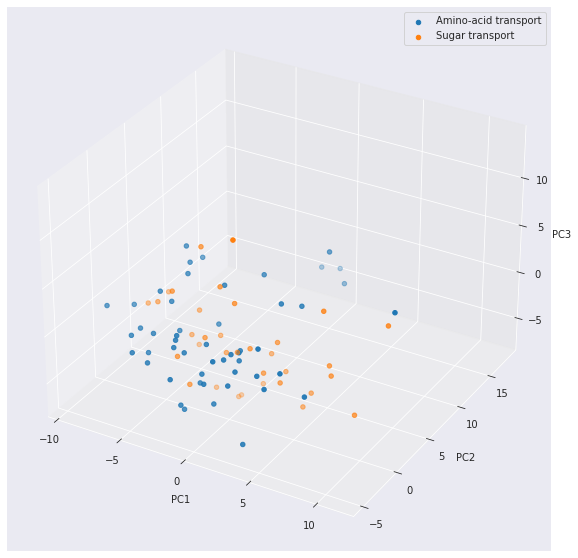

In [44]:
pca_plot_3d(df_paac, labels)

With PAAC, there is a hint of a pattern where amino acid transporters have higher variance in the PCs, but nothing obvious. RBF kernel could work, if we add more dimensions (i.e. more than two)

### PSSM plots


TypeError: pca_plot_3d() got an unexpected keyword argument 'index'

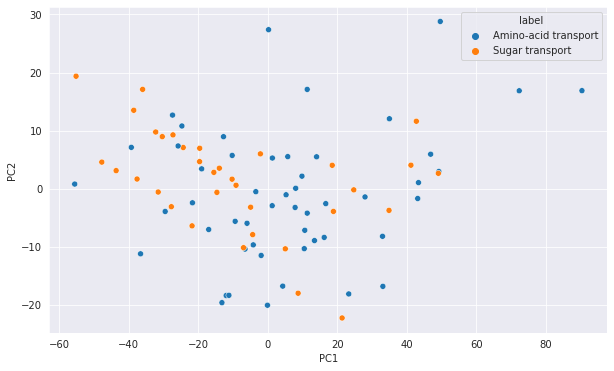

In [46]:
pca_plot_2d(df_pssm, labels)

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fdfdcf0fee0>)

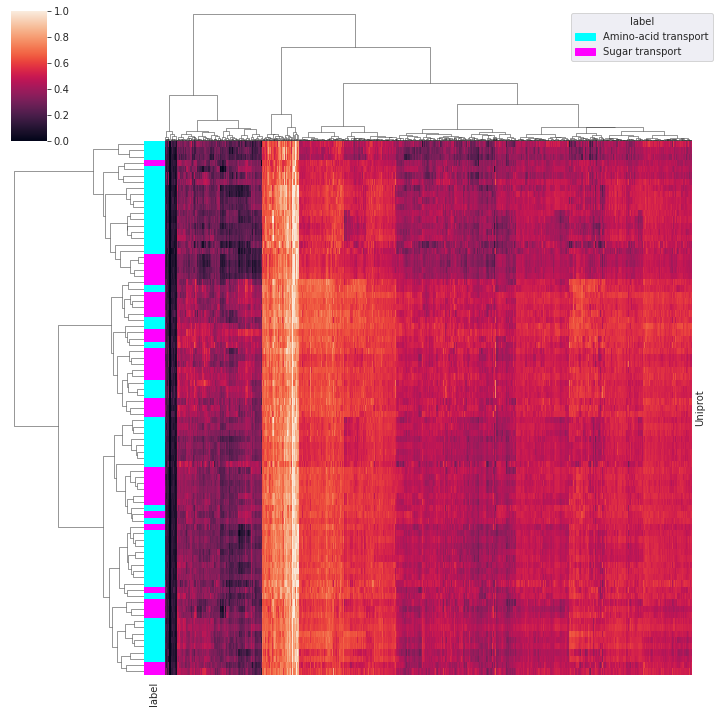

In [47]:
labeled_clustermap(df_pssm, labels)

## F score Plot

The feature importance values show glycine as the most important feature, followed by leucine. Both are typically more related to structural functions. The first electrically charged amino acid is aspartic acid, which appeared before in our dataset analysis. 

Another thing to note is that the order of amino acid importances looks very different from both a thaliana and e coli. this could hint at an incompatibility between the models

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

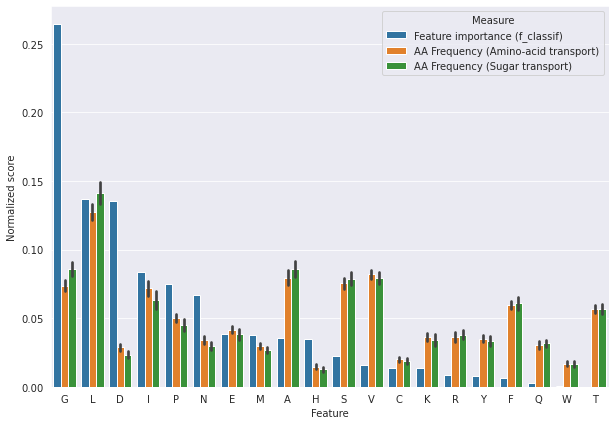

In [50]:
feature_importance_plot(df_aac, labels, method="f_classif")

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

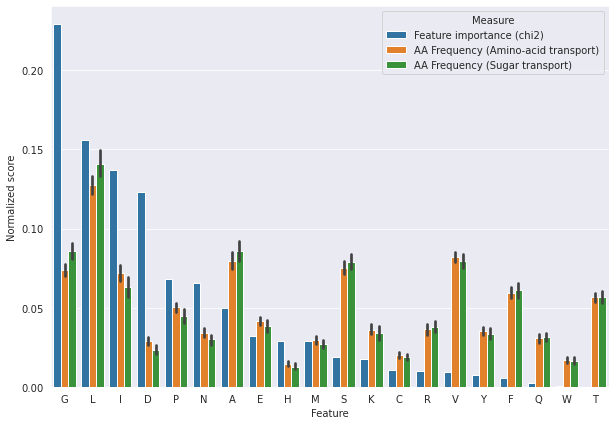

In [51]:
feature_importance_plot(df_aac, labels, method="chi2")